## Import Libraries

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import KNNImputer
from sklearn.model_selection import TimeSeriesSplit
from itertools import combinations, cycle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set default plot size and style
plt.rcParams['figure.figsize'] = [15, 8]
sns.set_style("whitegrid")

## Data Loading and EDA

#### For Generation Data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals
- PLANT_ID - ID of Solar Power Plant (common for the entire file)
- SOURCE_KEY - Inverter ID
- DC_POWER - Amount of DC power input to the inverter (SOURCE_KEY) at interval (in kW)
- AC_POWER - Amount of AC power generated by the inverter (SOURCE_KEY) at interval (in kW)
- DAILY_YIELD - Cumulative sum of power generated on that day, till that point in time
- TOTAL_YIELD - Total yield for the inverter till that point in time

#### For Weather Sensor Data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals
- PLANT_ID - ID of Solar Power Plant (common for the entire file)
- SOURCE_KEY - Sensor panel ID (Common for entire file, only one type of sensor panel for the plant)
- AMBIENT_TEMPERATURE - Ambient temperature at the plant
- MODULE_TEMPERATURE - Temperature reading for module attached to the sensor panel
- IRRADIATION - Amount of irradiation for the 15 minute interval

In [35]:
# Load and preprocess data
generation_data_p1 = pd.read_csv('../data/Plant_1_Generation_Data.csv')
generation_data_p1['DC_POWER'] = generation_data_p1['DC_POWER'].div(1000)
generation_data_p1['AC_POWER'] = generation_data_p1['AC_POWER'].div(100)
generation_data_p1['DATE_TIME'] = pd.to_datetime(generation_data_p1['DATE_TIME'], format='%d-%m-%Y %H:%M')
generation_data_p1.set_index('DATE_TIME', inplace=True)

weather_data_p1 = pd.read_csv('../data/Plant_1_Weather_Sensor_Data.csv')
weather_data_p1['DATE_TIME'] = pd.to_datetime(weather_data_p1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
weather_data_p1.set_index('DATE_TIME', inplace=True)
weather_data_p1 = weather_data_p1.drop('SOURCE_KEY', axis=1)

In [36]:
# Count SOURCE_KEY
generation_data_p1.SOURCE_KEY.nunique()

22

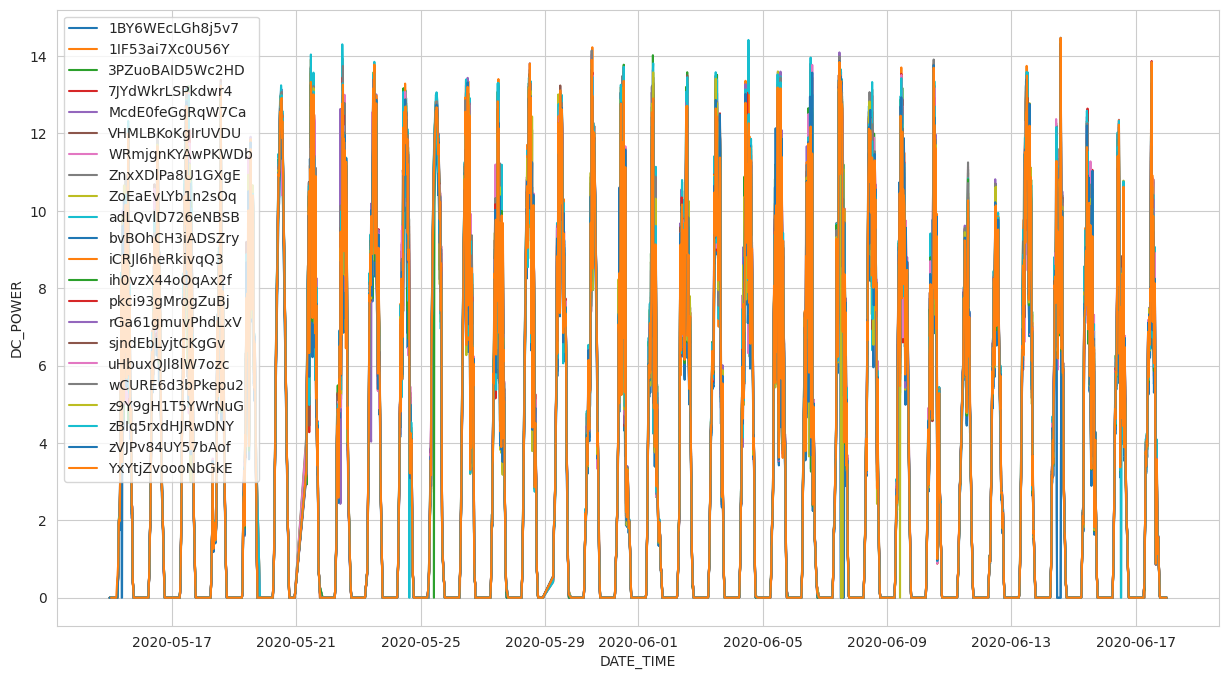

In [37]:
# Make a graph for each SOURCE_KEY
source_key = generation_data_p1.SOURCE_KEY.unique()
for sk in source_key:
    sns.lineplot(data=generation_data_p1[generation_data_p1['SOURCE_KEY']==sk], x=(generation_data_p1[generation_data_p1['SOURCE_KEY']==sk]).index, y=generation_data_p1['DC_POWER'][generation_data_p1['SOURCE_KEY']==sk], label=sk)

<Axes: xlabel='DATE_TIME', ylabel='IRRADIATION'>

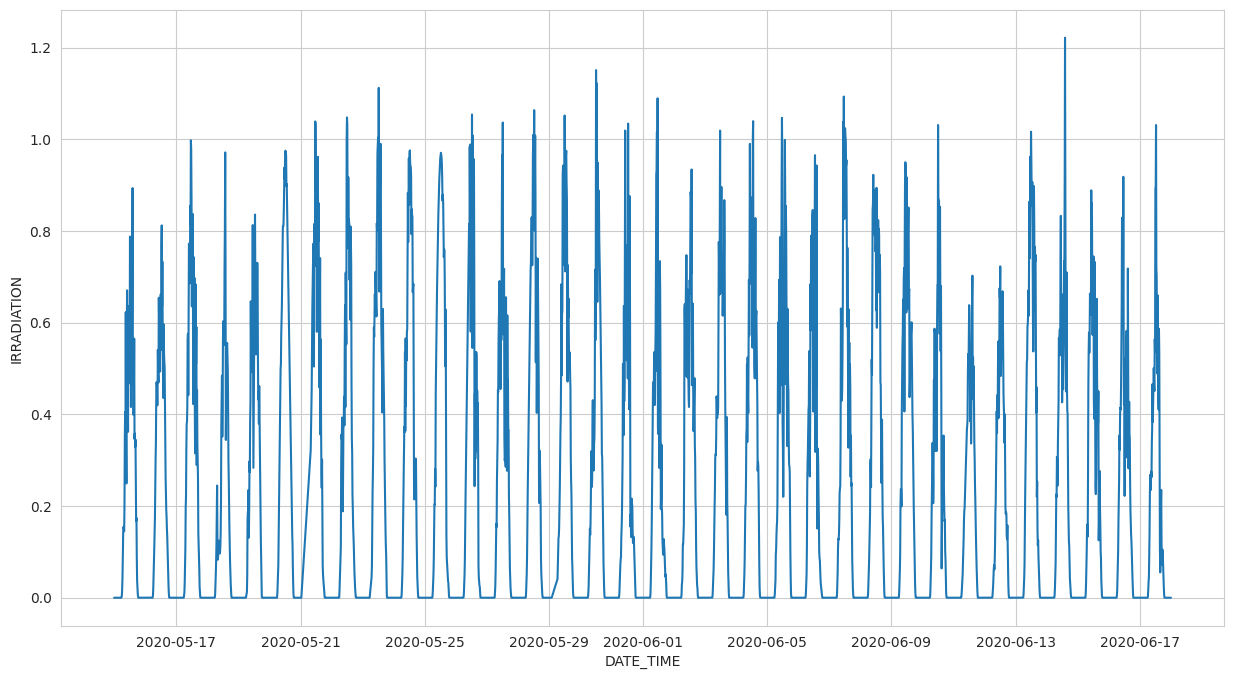

In [38]:
sns.lineplot(data=weather_data_p1, x=weather_data_p1.index, y='IRRADIATION')

In [39]:
# Drop SOURCE_KEY
generation_data_p1 = generation_data_p1.drop('SOURCE_KEY', axis=1)

In [40]:
# Resample to daily and merge
df_weather = weather_data_p1.resample('D').mean()
df_generation = generation_data_p1.resample('D').mean()
df_p1 = pd.merge(df_generation, df_weather, left_on='DATE_TIME', right_on='DATE_TIME', how='inner', suffixes=('_gen', '_weather'))

Text(0.5, 1.0, 'Irradiation versus the Daily Yield')

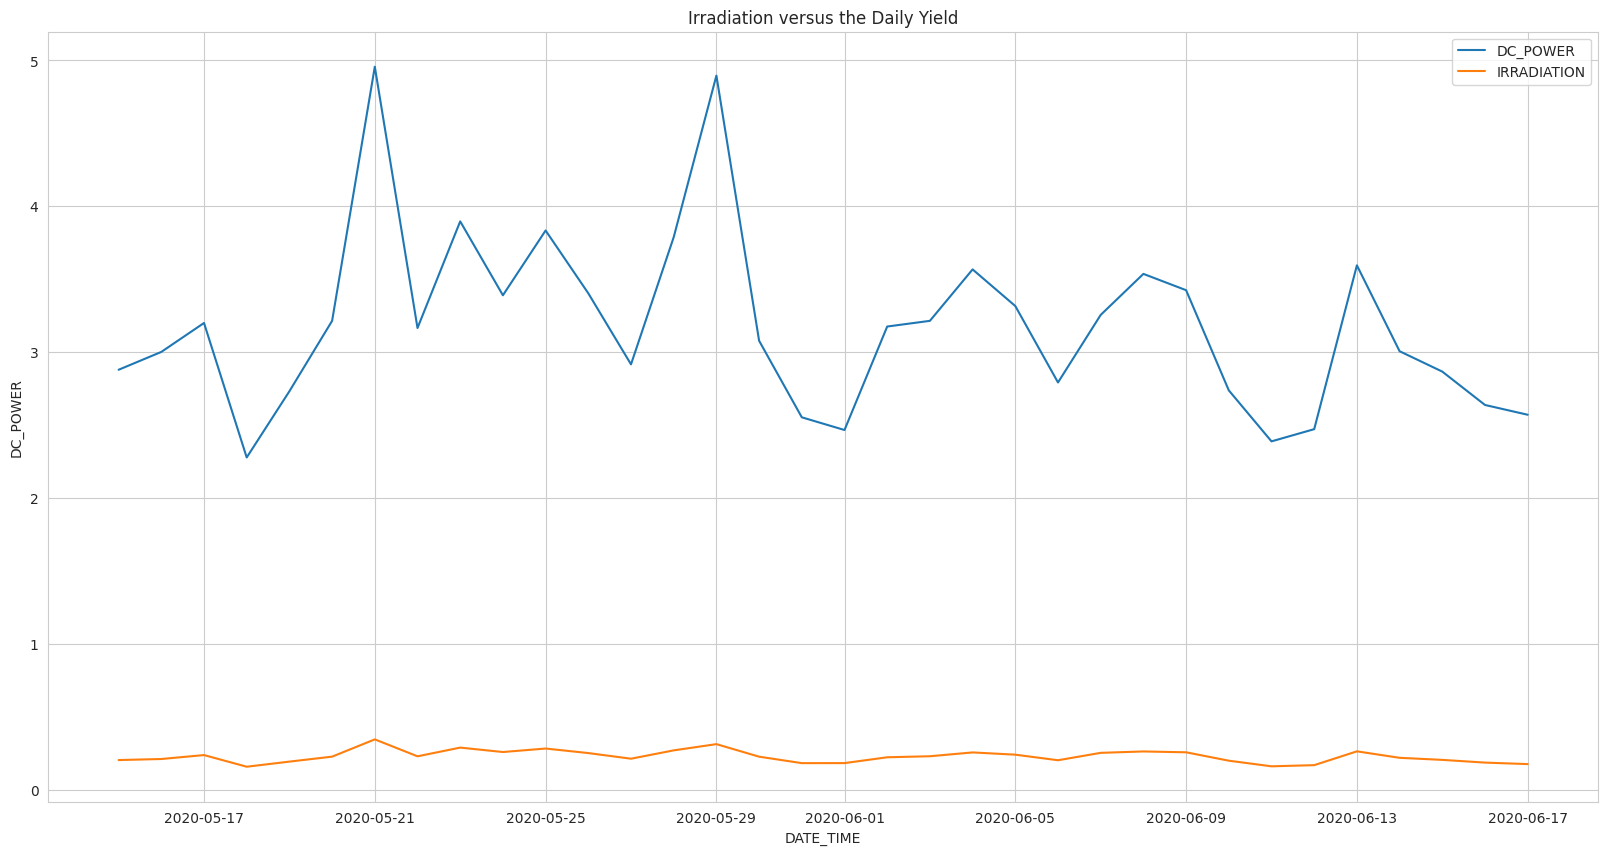

In [41]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df_p1, x=df_p1.index, y='DC_POWER', label='DC_POWER')
sns.lineplot(data=df_p1, x=df_p1.index, y='IRRADIATION', label='IRRADIATION')
plt.title('Irradiation versus the Daily Yield')

In [42]:
df = df_p1.drop(['PLANT_ID_weather', 'AC_POWER','TOTAL_YIELD', 'PLANT_ID_gen','DAILY_YIELD'], axis=1)

In [43]:
df_m2 = df_p1.copy()
df_m2['DC_POWER-1'] = df_m2['DC_POWER'].shift(1)
df_m2['IRRADIATION-1'] = df_m2['IRRADIATION'].shift(1)
df_m2['AMBIENT_TEMPERATURE-1'] = df_m2['AMBIENT_TEMPERATURE'].shift(1)
df_m2['MODULE_TEMPERATURE-1'] = df_m2['MODULE_TEMPERATURE'].shift(1)
df_m2 = df_m2.drop(['PLANT_ID_weather', 'AC_POWER','TOTAL_YIELD', 'PLANT_ID_gen','DAILY_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], axis=1)
df_m2 = df_m2.iloc[1:, :]

<Axes: >

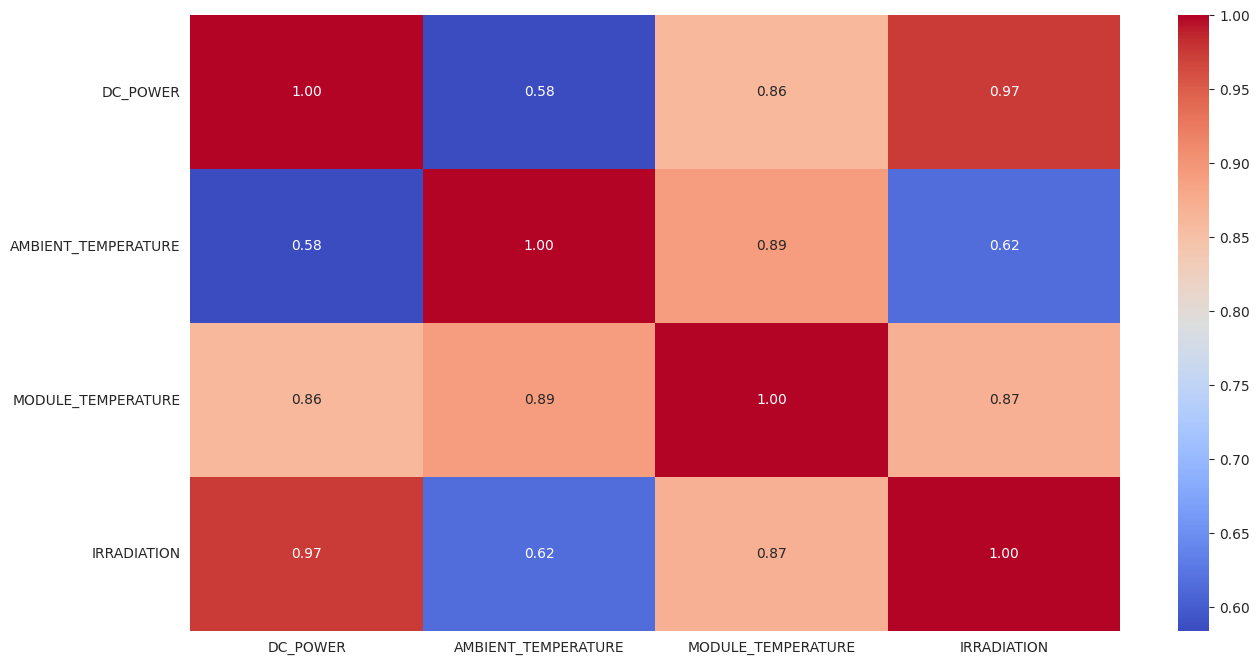

In [44]:
# get correlations for all columns
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

<Axes: >

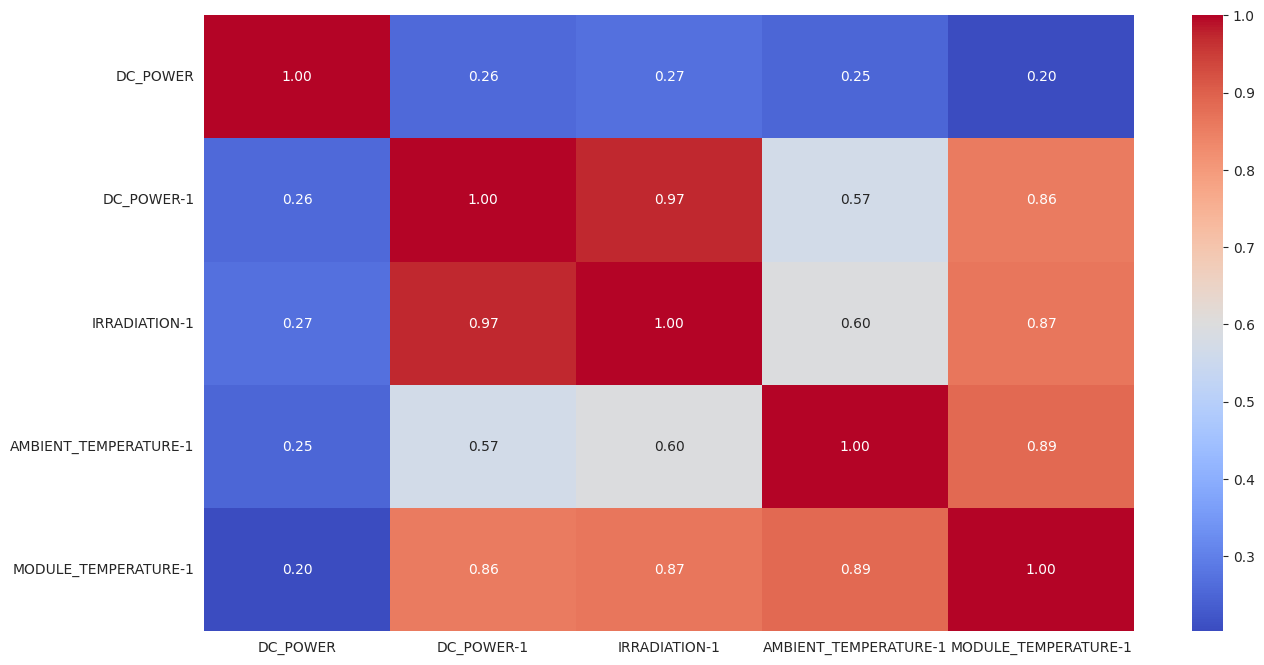

In [45]:
sns.heatmap(df_m2.corr(), annot=True, cmap='coolwarm', fmt=".2f")

## Preprocessing

In [46]:
df_m1 = df_m2.drop(['MODULE_TEMPERATURE-1', 'AMBIENT_TEMPERATURE-1', 'IRRADIATION-1'], axis=1)

In [47]:
# Resample to hourly and merge
df_weather_hrs = weather_data_p1.resample('H').mean()
df_generation_hrs = generation_data_p1.resample('H').mean()
df_p1_hrs = pd.merge(df_generation_hrs, df_weather_hrs, left_on='DATE_TIME', right_on='DATE_TIME', how='inner', suffixes=('_gen', '_weather'))
df_hrs = df_p1_hrs.drop(['PLANT_ID_gen', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'PLANT_ID_weather'], axis=1)

In [48]:
# Add an hour column
df_hrs['hour'] = df_hrs.index.hour

In [49]:
# Select desired columns
cols_to_process = ['DC_POWER','MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE', 'IRRADIATION']

In [50]:
# Process and reshape the DataFrame
df_hrs_processed = (
    df_hrs.set_index('hour', append=True)[cols_to_process]
    .unstack(level=-1)
    .groupby(level=0)
    .first()
)

# Rename the columns
df_hrs_processed.columns = [f'{col}-{hour:02d}' for col, hour in df_hrs_processed.columns]

# Keep only the first row (00:00:00) for each day
df_hrs_processed_f = df_hrs_processed.groupby(df_hrs_processed.index.date).first()

# Create KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Fit and transform data to impute missing values
imputed_data = imputer.fit_transform(df_hrs_processed_f)

# Recreate DataFrame with imputed values and original column names
df_hrs_imputed = pd.DataFrame(imputed_data, index=df_hrs_processed_f.index, columns=df_hrs_processed_f.columns)

df_hrs_imputed_2 = df_hrs_imputed.shift(periods=1)
df_hrs_imputed_f = df_hrs_imputed_2.iloc[1:]

## Model Training and Results

In [51]:
test_size = 7

### Univariate one-day-ahead prediction with 1 lag

In [52]:
df_train_m1 = df_m1[:-test_size]
df_test_m1 = df_m1[-test_size:]
X_train_m1 = df_train_m1.drop('DC_POWER', axis=1)
y_train_m1 = df_train_m1.drop('DC_POWER-1', axis=1)
X_test_m1 = df_test_m1.drop('DC_POWER', axis=1)
y_test_m1 = df_test_m1.drop('DC_POWER-1', axis=1)
m1 = Lasso()
m1.fit(X_train_m1,y_train_m1)
y_pred_m1 = m1.predict(X_test_m1)
mean_squared_error_m1 = mse(y_test_m1, y_pred_m1, squared=False)

# Get the coefficients
coef_m1 = pd.Series(m1.coef_, index=X_train_m1.columns)
print("Lasso picked " + str(sum(coef_m1 != 0)) + " features and eliminated the other " +  str(sum(coef_m1 == 0)) + " features")
print("Features with non-zero coefficients:")
print(coef_m1[coef_m1 != 0])
print(f"RMSE for test set : {mean_squared_error_m1:.5}")

Lasso picked 0 features and eliminated the other 1 features
Features with non-zero coefficients:
Series([], dtype: float64)
RMSE for test set : 0.63744


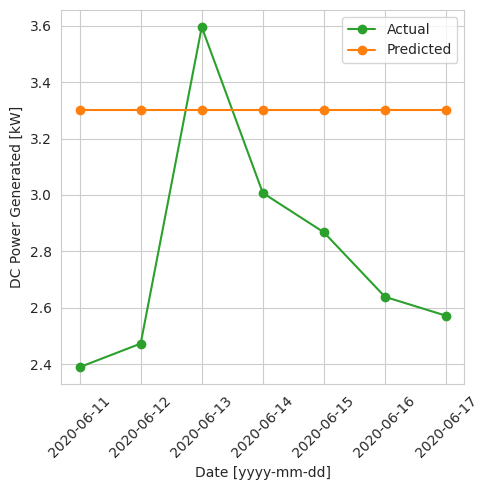

In [53]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the actual DC POWER values from the test set
ax.plot(df_test_m1.index, df_test_m1['DC_POWER'], color='#2ca02c', marker='o', label='Actual')  
# Plot model predictions for ONLY the test set
ax.plot(X_test_m1.index, y_pred_m1, color='#ff7f0e', label='Predicted', marker='o')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

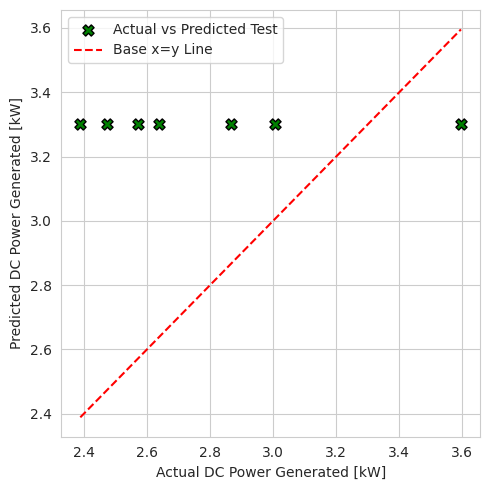

In [54]:
fig, ax = plt.subplots(figsize=(5, 5))
# Plot using the target column from y_test_m1
ax.scatter(y_test_m1['DC_POWER'], y_pred_m1, color='g', label='Actual vs Predicted Test', marker='X', edgecolors='k', s=64)
# Calculate min and max using the target column
min_val = min(min(y_test_m1['DC_POWER']), min(y_pred_m1))
max_val = max(max(y_test_m1['DC_POWER']), max(y_pred_m1))
# Plot the base line x=y
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x=y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
#ax.set_title('Actual vs Predicted DC Power Generation')
ax.legend()
plt.tight_layout()
plt.show()

### Multivariate (multiple features) one-day-ahead prediction with 1 lag

In [55]:
df_train_m2 = df_m2[:-test_size]
df_test_m2 = df_m2[-test_size:]
X_train_m2 = df_train_m2.drop('DC_POWER', axis=1)
y_train_m2 = df_train_m2.drop(['DC_POWER-1', 'AMBIENT_TEMPERATURE-1', 'IRRADIATION-1','MODULE_TEMPERATURE-1'], axis=1)
X_test_m2 = df_test_m2.drop('DC_POWER', axis=1)
y_test_m2 = df_test_m2.drop(['DC_POWER-1', 'AMBIENT_TEMPERATURE-1', 'IRRADIATION-1','MODULE_TEMPERATURE-1'], axis=1)
m2 = Lasso()
m2.fit(X_train_m2,y_train_m2)
y_pred_m2 = m2.predict(X_test_m2)
mean_squared_error_m2 = mse(y_test_m2, y_pred_m2, squared=False)

# Get the coefficients
coef_m2 = pd.Series(m2.coef_, index=X_train_m2.columns)
print("Lasso picked " + str(sum(coef_m2 != 0)) + " features and eliminated the other " +  str(sum(coef_m2 == 0)) + " features")
print("Features with non-zero coefficients:")
print(coef_m2[coef_m2 != 0])
print(f"RMSE for test set : {mean_squared_error_m2:.5}")

Lasso picked 0 features and eliminated the other 4 features
Features with non-zero coefficients:
Series([], dtype: float64)
RMSE for test set : 0.63744


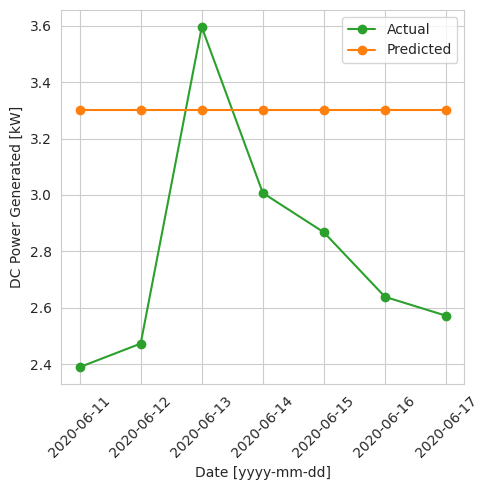

In [56]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the actual DC POWER values from the test set
ax.plot(df_test_m2.index, df_test_m2['DC_POWER'], color='#2ca02c', marker='o', label='Actual')  
# Plot model predictions for ONLY the test set
ax.plot(X_test_m2.index, y_pred_m2, color='#ff7f0e', label='Predicted', marker='o')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

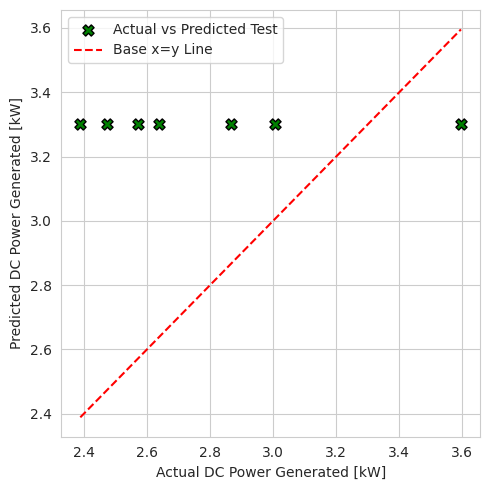

In [57]:
fig, ax = plt.subplots(figsize=(5, 5))
# Plot using the target column from y_test_m2
ax.scatter(y_test_m2['DC_POWER'], y_pred_m2, color='g', label='Actual vs Predicted Test', marker='X', edgecolors='k', s=64)
# Calculate min and max using the target column
min_val = min(min(y_test_m2['DC_POWER']), min(y_pred_m2))
max_val = max(max(y_test_m2['DC_POWER']), max(y_pred_m2))
# Plot the base line x=y
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x=y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
#ax.set_title('Actual vs Predicted DC Power Generation')
ax.legend()
plt.tight_layout()
plt.show()

### Multivariate (hourly train data as features) one-day-ahead prediction with 1 lag

#### Using LassoCV


Feature Set: ['DC_POWER']
Best alpha: 0.225


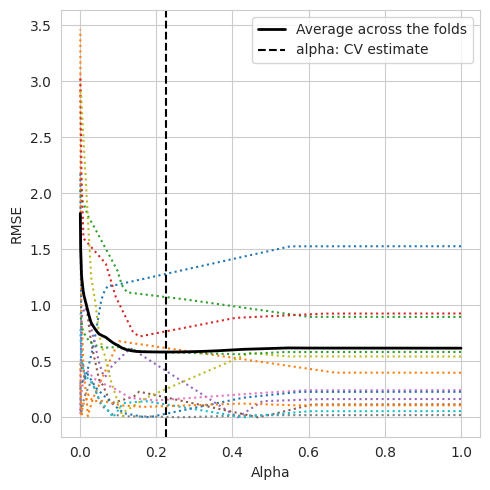

RMSE for test set: 0.5422818290642769
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03629597
  0.07819416  0.          0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.        ]

Feature Set: ['IRRADIATION']
Best alpha: 0.021


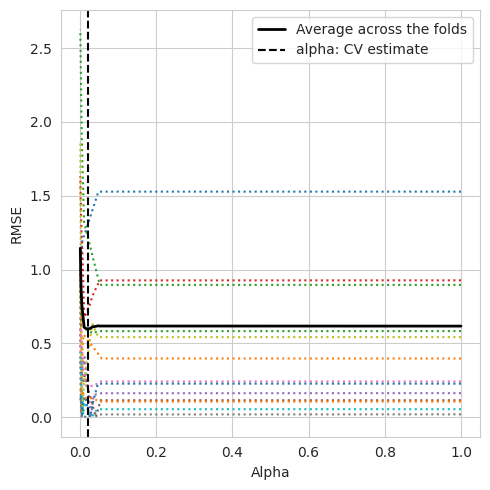

RMSE for test set: 0.5421600843664913
Coefficients: [ 0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.32696873
  0.81756207  0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.        ]

Feature Set: ['MODULE_TEMPERATURE']
Best alpha: 0.872


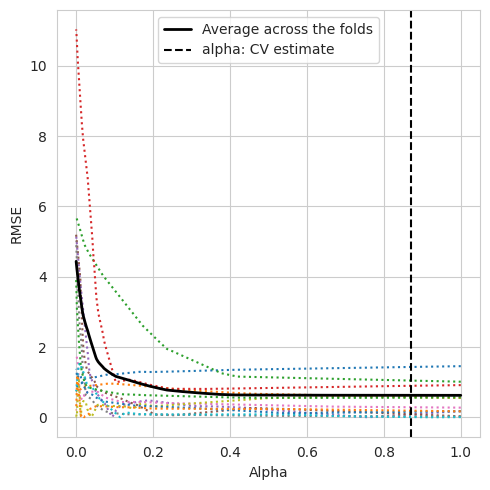

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.       ]

Feature Set: ['AMBIENT_TEMPERATURE']
Best alpha: 0.253


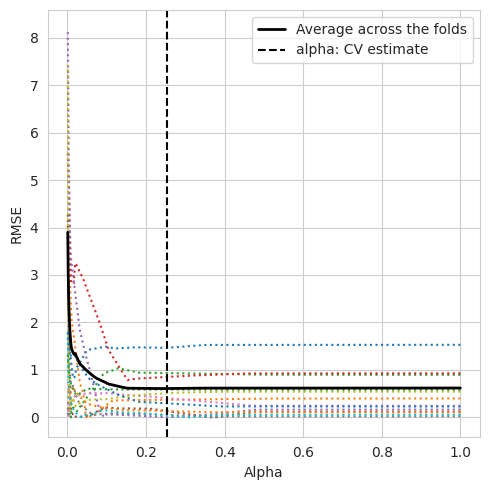

RMSE for test set: 0.5932108690976927
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.01349966  0.          0.          0.          0.          0.
  0.02017997  0.          0.          0.         -0.         -0.        ]

Feature Set: ['DC_POWER', 'IRRADIATION']
Best alpha: 0.225


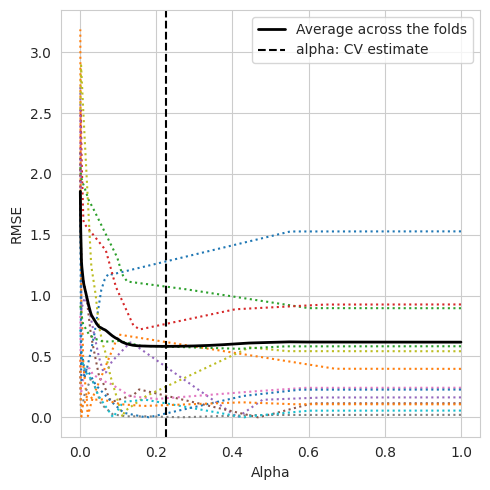

RMSE for test set: 0.5422818290642769
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03629597
  0.07819416  0.          0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.        ]

Feature Set: ['DC_POWER', 'MODULE_TEMPERATURE']
Best alpha: 0.872


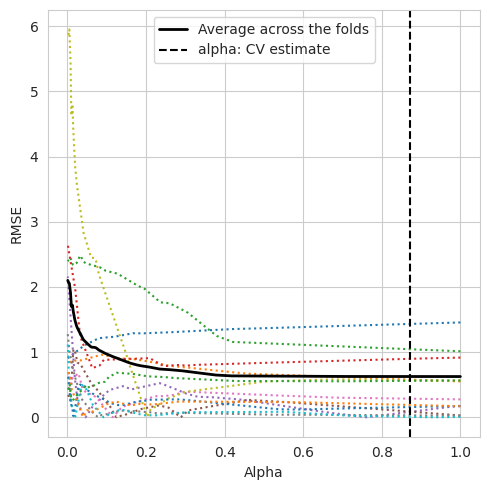

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.       ]

Feature Set: ['DC_POWER', 'AMBIENT_TEMPERATURE']
Best alpha: 0.20600000000000002


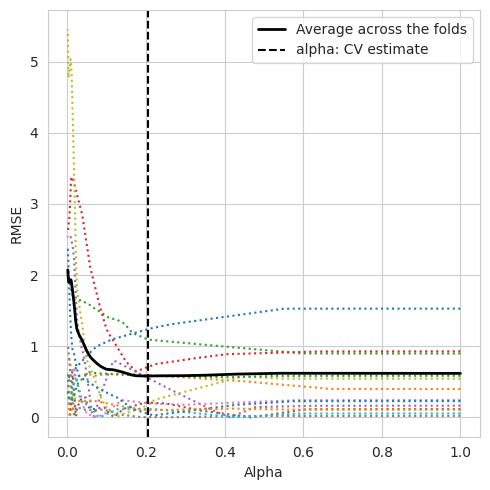

RMSE for test set: 0.53835442932977
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.04104662
  0.08213017  0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.        ]

Feature Set: ['IRRADIATION', 'MODULE_TEMPERATURE']
Best alpha: 0.872


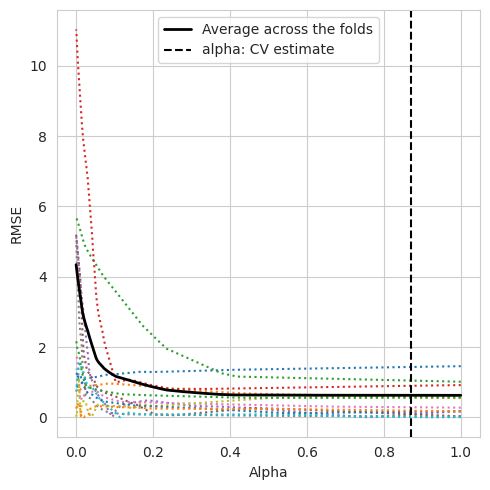

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.        -0.         0.         0.         0.         0.       ]

Feature Set: ['IRRADIATION', 'AMBIENT_TEMPERATURE']
Best alpha: 0.253


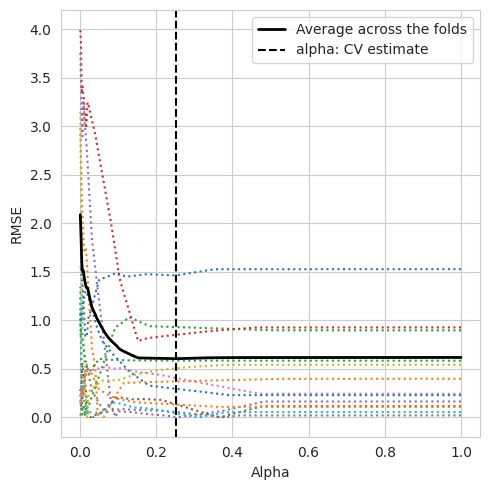

RMSE for test set: 0.5932108690976927
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.01349966  0.          0.          0.          0.          0.
  0.02017997  0.          0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.         -0.          0.          0.          0.          0.        ]

Feature Set: ['MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']
Best alpha: 0.872


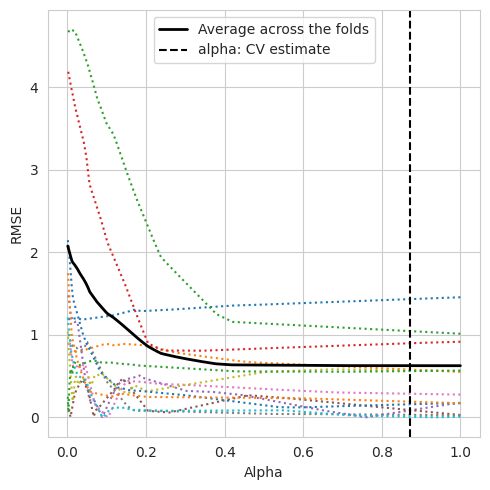

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.       ]

Feature Set: ['DC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']
Best alpha: 0.872


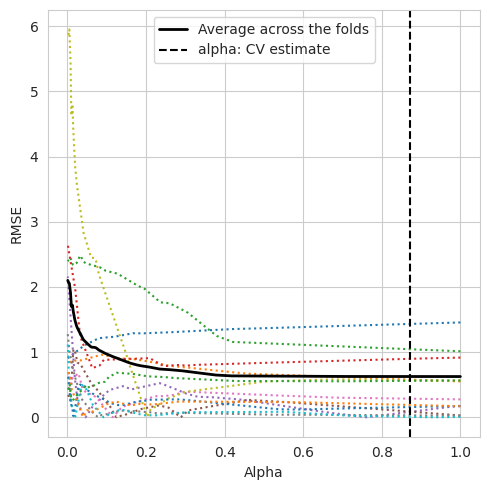

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.        -0.         0.         0.         0.         0.       ]

Feature Set: ['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE']
Best alpha: 0.20600000000000002


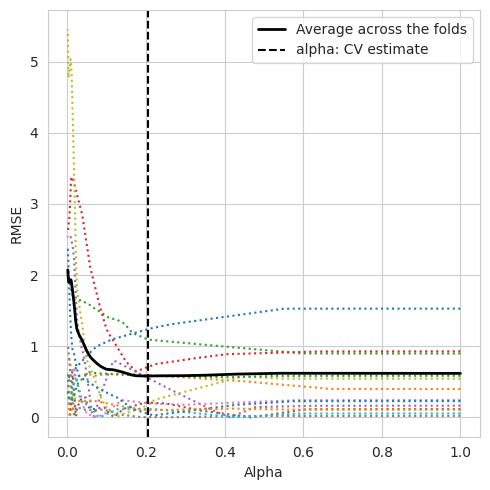

RMSE for test set: 0.53835442932977
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.04104662
  0.08213017  0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.         -0.
  0.          0.          0.          0.          0.         -0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.          0.         -0.         -0.
  0.          0.          0.          0.          0.          0.        ]

Feature Set: ['DC_POWER', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']
Best alpha: 0.872


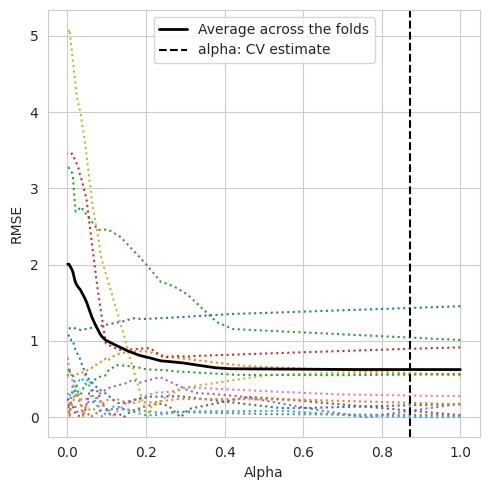

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.       ]

Feature Set: ['IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']
Best alpha: 0.872


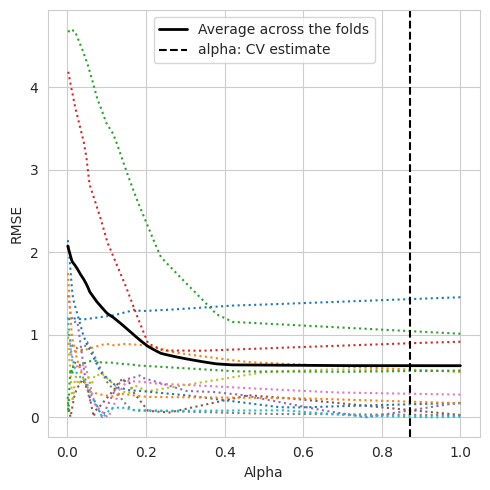

RMSE for test set: 0.5694141106837161
Coefficients: [ 0.         0.         0.        -0.        -0.        -0.
 -0.         0.         0.         0.         0.         0.
  0.0120346  0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.        -0.
  0.         0.         0.         0.         0.        -0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        -0.         0.
  0.        -0.         0.         0.         0.         0.       ]


In [58]:
# Define all features 
all_features = ['DC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# Generate all possible feature sets 
feature_sets = []
for r in range(1, len(all_features)):
    for combination in combinations(all_features, r):
        feature_sets.append(list(combination))

# Dictionary to store predictions for each feature set
predictions_dict = {}

# Iterate over feature sets
for feature_set in feature_sets:
    print(f"\nFeature Set: {feature_set}")

    # Select relevant columns from the preprocessed 24-hour data
    X = df_hrs_imputed_f[
        [col for col in df_hrs_imputed_f.columns if any(feat in col for feat in feature_set)]
    ]
    y = df_m1['DC_POWER']  # Target variable is always 'DC_POWER'

    # Split the data into training and testing sets
    X_train, X_test = X[:-test_size], X[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]

    # Use TimeSeriesSplit for cross-validation within the training set
    tscv = TimeSeriesSplit(n_splits=13)

    # Find best alpha using LassoCV with TimeSeriesSplit
    lasso_cv = LassoCV(alphas=np.linspace(0.001, 1, 1000), cv=tscv)
    lasso_cv.fit(X_train, y_train)
    
    # Extract the best alpha
    best_alpha = lasso_cv.alpha_
    mse_path_mean = lasso_cv.mse_path_.mean(axis=1)
    rmse_path_mean = np.sqrt(mse_path_mean)
    best_rmse = rmse_path_mean.min()
    print(f"Best alpha: {best_alpha}")

    # Plot RMSE vs. alpha
    plt.figure(figsize=(5, 5))  # Set figure size to make it a square
    for i in range(lasso_cv.mse_path_.shape[1]):
        plt.plot(lasso_cv.alphas_, np.sqrt(lasso_cv.mse_path_[:, i]), ':')
    plt.plot(lasso_cv.alphas_, rmse_path_mean, 'k', label='Average across the folds', linewidth=2)
    # Mark the best alpha
    plt.axvline(best_alpha, linestyle='--', color='k', label='alpha: CV estimate')
    plt.xlabel('Alpha')
    plt.ylabel('RMSE')
    #plt.title(f'RMSE vs Alpha for n_splits in TimeSeriesSplit')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Fit Lasso model with best alpha
    model = Lasso(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mse(y_test, y_pred, squared=False)
    print(f"RMSE for test set: {test_rmse}")
    print("Coefficients:", model.coef_)

    # Store predictions in dictionary
    predictions_dict[str(feature_set)] = pd.Series(y_pred.flatten(), index=df_hrs_imputed_f.index[-test_size:])

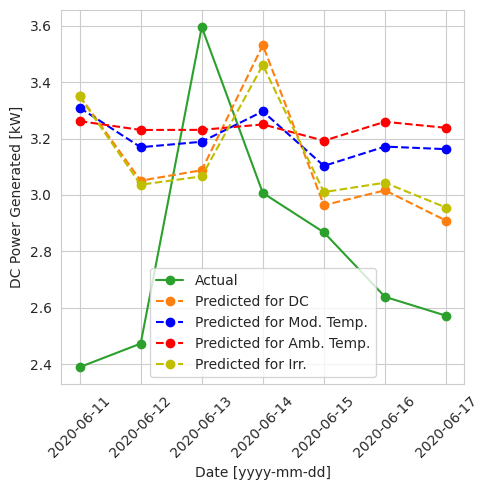

In [59]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the actual DC POWER values from the test set
y_test_series = pd.Series(y[-test_size:].values.flatten(), index=df.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')
# Plot model predictions for each chosen feature set
y_pred_D_series = predictions_dict[str(['DC_POWER'])]
y_pred_M_series = predictions_dict[str(['MODULE_TEMPERATURE'])]
y_pred_A_series = predictions_dict[str(['AMBIENT_TEMPERATURE'])]
y_pred_I_series = predictions_dict[str(['IRRADIATION'])]
ax.plot(y_pred_D_series.index, y_pred_D_series, color='#ff7f0e', label='Predicted for DC', marker='o', linestyle='--')
ax.plot(y_pred_M_series.index, y_pred_M_series, color='b', label='Predicted for Mod. Temp.', marker='o', linestyle='--')
ax.plot(y_pred_A_series.index, y_pred_A_series, color='r', label='Predicted for Amb. Temp.', marker='o', linestyle='--')
ax.plot(y_pred_I_series.index, y_pred_I_series, color='y', label='Predicted for Irr.', marker='o', linestyle='--')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
plt.show()

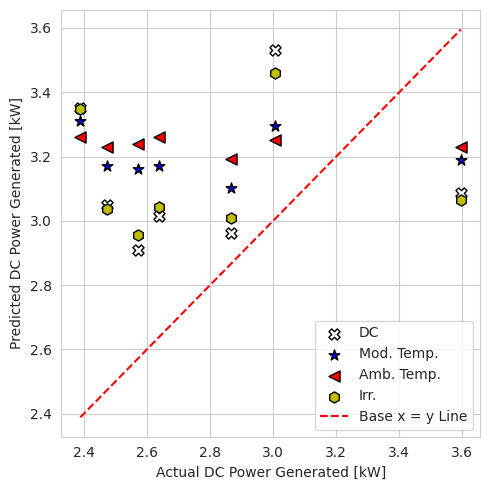

In [60]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
y_test_flat = y[-test_size:].values.flatten()
y_test_series = pd.Series(y_test_flat, index=df.index[-test_size:])
# Plot model predictions for each chosen feature set
y_pred_D_series = predictions_dict[str(['DC_POWER'])]
y_pred_M_series = predictions_dict[str(['MODULE_TEMPERATURE'])]
y_pred_A_series = predictions_dict[str(['AMBIENT_TEMPERATURE'])]
y_pred_I_series = predictions_dict[str(['IRRADIATION'])]
sc1 = ax.scatter(y_test_series, y_pred_D_series, color='w', label='DC', marker='X', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, y_pred_M_series, color='b', label='Mod. Temp.', marker='*', edgecolors='k', s=64)
sc3 = ax.scatter(y_test_series, y_pred_A_series, color='r', label='Amb. Temp.', marker='<', edgecolors='k', s=64)
sc4 = ax.scatter(y_test_series, y_pred_I_series, color='y', label='Irr.', marker='h', edgecolors='k', s=64)
# Base line for comparison
min_val = min(y_test_series.min(), min(y_pred_series.min() for y_pred_series in predictions_dict.values()))
max_val = max(y_test_series.max(), max(y_pred_series.max() for y_pred_series in predictions_dict.values()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
plt.show()

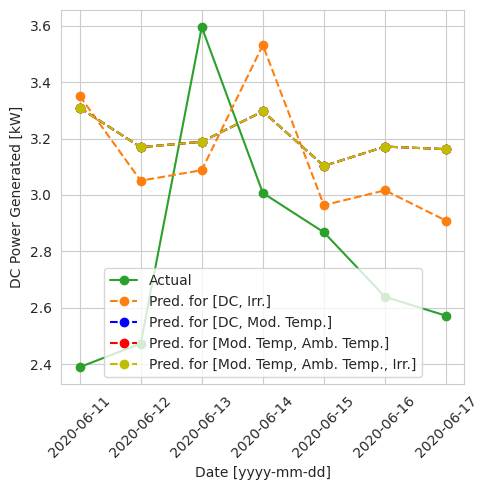

In [61]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the actual DC POWER values from the test set
y_test_series = pd.Series(y[-test_size:].values.flatten(), index=df.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')
# Plot model predictions for each chosen feature set
y_pred_DI_series = predictions_dict[str(['DC_POWER', 'IRRADIATION'])]
y_pred_DM_series = predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])]
y_pred_MA_series = predictions_dict[str(['MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'])]
y_pred_MAI_series = predictions_dict[str(['IRRADIATION','MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'])]
ax.plot(y_pred_DI_series.index, y_pred_DI_series, color='#ff7f0e', label='Pred. for [DC, Irr.]', marker='o', linestyle='--')
ax.plot(y_pred_DM_series.index, y_pred_DM_series, color='b', label='Pred. for [DC, Mod. Temp.]', marker='o', linestyle='--')
ax.plot(y_pred_MA_series.index, y_pred_MA_series, color='r', label='Pred. for [Mod. Temp, Amb. Temp.]', marker='o', linestyle='--')
ax.plot(y_pred_MAI_series.index, y_pred_MAI_series, color='y', label='Pred. for [Mod. Temp, Amb. Temp., Irr.]', marker='o', linestyle='--')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
plt.show()

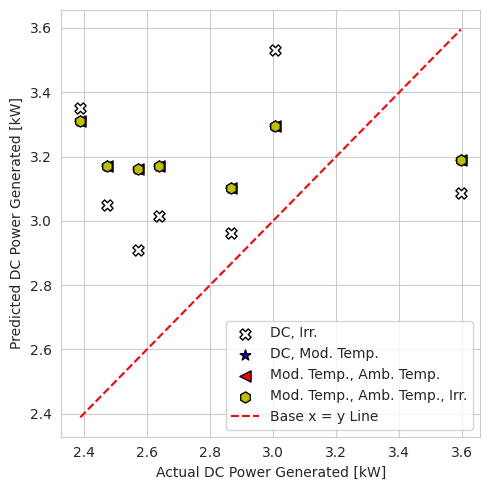

In [62]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
y_test_flat = y[-test_size:].values.flatten()
y_test_series = pd.Series(y_test_flat, index=df.index[-test_size:])
# Manually plot specific feature combinations
y_pred_DI_series = predictions_dict[str(['DC_POWER', 'IRRADIATION'])]
y_pred_DM_series = predictions_dict[str(['DC_POWER', 'MODULE_TEMPERATURE'])]
y_pred_MA_series = predictions_dict[str(['MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'])]
y_pred_MAI_series = predictions_dict[str(['IRRADIATION','MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE'])]
sc1 = ax.scatter(y_test_series, y_pred_DI_series, color='w', label='DC, Irr.', marker='X', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, y_pred_DM_series, color='b', label='DC, Mod. Temp.', marker='*', edgecolors='k', s=64)
sc3 = ax.scatter(y_test_series, y_pred_MA_series, color='r', label='Mod. Temp., Amb. Temp.', marker='<', edgecolors='k', s=64)
sc4 = ax.scatter(y_test_series, y_pred_MAI_series, color='y', label='Mod. Temp., Amb. Temp., Irr.', marker='h', edgecolors='k', s=64)
# Base line for comparison
min_val = min(y_test_series.min(), min(y_pred_series.min() for y_pred_series in predictions_dict.values()))
max_val = max(y_test_series.max(), max(y_pred_series.max() for y_pred_series in predictions_dict.values()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
plt.show()

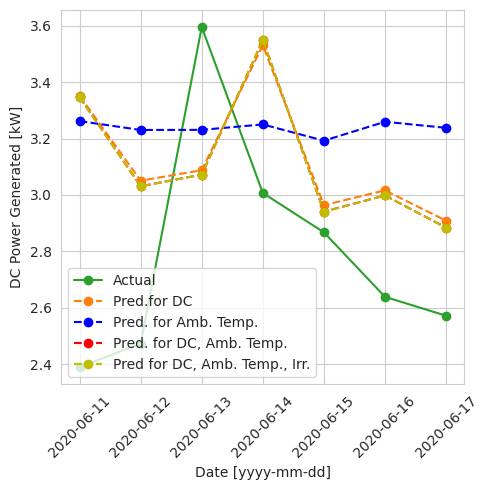

In [63]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(5, 5))
# Plot the actual DC POWER values from the test set
y_test_series = pd.Series(y[-test_size:].values.flatten(), index=df.index[-test_size:])
ax.plot(y_test_series.index, y_test_series, color='#2ca02c', marker='o', label='Actual')
# Plot model predictions for each chosen feature set
y_pred_D_series = predictions_dict[str(['DC_POWER'])]
y_pred_A_series = predictions_dict[str(['AMBIENT_TEMPERATURE'])]
y_pred_DA_series = predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])]
y_pred_DAI_series = predictions_dict[str(['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE'])]
ax.plot(y_pred_D_series.index, y_pred_D_series, color='#ff7f0e', label='Pred.for DC', marker='o', linestyle='--')
ax.plot(y_pred_M_series.index, y_pred_A_series, color='b', label='Pred. for Amb. Temp.', marker='o', linestyle='--')
ax.plot(y_pred_DA_series.index, y_pred_DA_series, color='r', label='Pred. for DC, Amb. Temp.', marker='o', linestyle='--')
ax.plot(y_pred_DAI_series.index, y_pred_DAI_series, color='y', label='Pred for DC, Amb. Temp., Irr.', marker='o', linestyle='--')
ax.set_xlabel('Date [yyyy-mm-dd]')
ax.set_ylabel('DC Power Generated [kW]')
plt.xticks(rotation=45)
plt.tight_layout()
ax.legend()
plt.show()

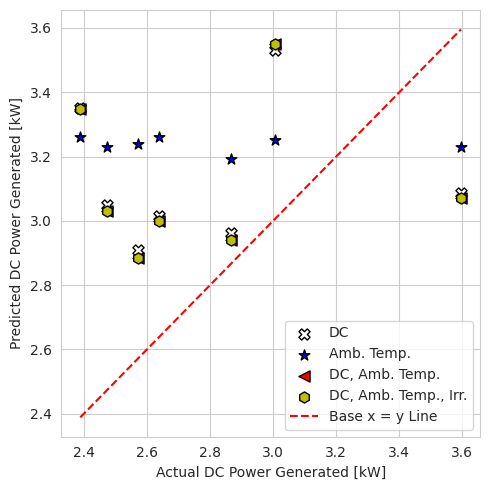

In [64]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
y_test_flat = y[-test_size:].values.flatten()
y_test_series = pd.Series(y_test_flat, index=df.index[-test_size:])
# Manually plot specific feature combinations
y_pred_D_series = predictions_dict[str(['DC_POWER'])]
y_pred_A_series = predictions_dict[str(['AMBIENT_TEMPERATURE'])]
y_pred_DA_series = predictions_dict[str(['DC_POWER', 'AMBIENT_TEMPERATURE'])]
y_pred_DAI_series = predictions_dict[str(['DC_POWER', 'IRRADIATION', 'AMBIENT_TEMPERATURE'])]
sc1 = ax.scatter(y_test_series, y_pred_D_series, color='w', label='DC', marker='X', edgecolors='k', s=64)
sc2 = ax.scatter(y_test_series, y_pred_A_series, color='b', label='Amb. Temp.', marker='*', edgecolors='k', s=64)
sc3 = ax.scatter(y_test_series, y_pred_DA_series, color='r', label='DC, Amb. Temp.', marker='<', edgecolors='k', s=64)
sc4 = ax.scatter(y_test_series, y_pred_DAI_series, color='y', label='DC, Amb. Temp., Irr.', marker='h', edgecolors='k', s=64)
# Base line for comparison
min_val = min(y_test_series.min(), min(y_pred_series.min() for y_pred_series in predictions_dict.values()))
max_val = max(y_test_series.max(), max(y_pred_series.max() for y_pred_series in predictions_dict.values()))
ax.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='r', label='Base x = y Line')
ax.set_xlabel('Actual DC Power Generated [kW]')
ax.set_ylabel('Predicted DC Power Generated [kW]')
plt.tight_layout()
ax.legend()
plt.show()

Number of splits: 2, RMSE: 0.63743511769581
Number of splits: 3, RMSE: 0.63743511769581
Number of splits: 4, RMSE: 0.63743511769581
Number of splits: 5, RMSE: 0.63743511769581
Number of splits: 6, RMSE: 0.63743511769581
Number of splits: 7, RMSE: 0.63743511769581
Number of splits: 8, RMSE: 0.63743511769581
Number of splits: 9, RMSE: 0.63743511769581
Number of splits: 10, RMSE: 0.63743511769581
Number of splits: 11, RMSE: 0.63743511769581
Number of splits: 12, RMSE: 0.63743511769581
Number of splits: 13, RMSE: 0.5422818290642769
Number of splits: 14, RMSE: 0.63743511769581
Number of splits: 15, RMSE: 0.63743511769581
Number of splits: 16, RMSE: 0.63743511769581
Number of splits: 17, RMSE: 0.63743511769581
Number of splits: 18, RMSE: 0.63743511769581
Number of splits: 19, RMSE: 0.63743511769581
Number of splits: 20, RMSE: 0.63743511769581
Number of splits: 21, RMSE: 0.63743511769581
Number of splits: 22, RMSE: 0.63743511769581
Number of splits: 23, RMSE: 0.63743511769581
Number of splits

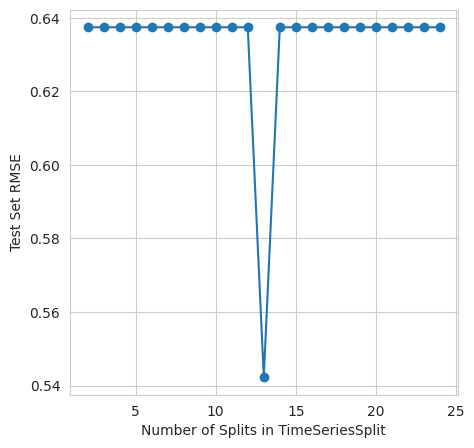

In [65]:
# Feature set for 'DC_POWER' only
feature_set = ['DC_POWER']

# Select relevant columns from the preprocessed 24-hour data
X = df_hrs_imputed_f[
    [col for col in df_hrs_imputed_f.columns if any(feat in col for feat in feature_set)]
]
y = df_m1['DC_POWER']  # Target variable is always 'DC_POWER'

# Split the data into training and testing sets
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# List to store RMSE values
rmse_values = []

# Iterate over different values for the number of splits in TimeSeriesSplit
split_values = range(2, 25)  # Our train set has 26 samples
for n_splits in split_values:
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Find best alpha using LassoCV with TimeSeriesSplit
    lasso_cv = LassoCV(alphas=np.linspace(0.001, 1, 1000), cv=tscv)
    lasso_cv.fit(X_train, y_train)
    
    # Extract the best alpha
    best_alpha = lasso_cv.alpha_
    
    # Fit Lasso model with best alpha
    model = Lasso(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mse(y_test, y_pred, squared=False)
    rmse_values.append(test_rmse)
    print(f"Number of splits: {n_splits}, RMSE: {test_rmse}")

# Plot RMSE vs. Number of Splits
plt.figure(figsize=(5, 5))
plt.plot(split_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('Number of Splits in TimeSeriesSplit')
plt.ylabel('Test Set RMSE')
plt.grid(True)
plt.show()

Number of splits: 2, RMSE: 0.63743511769581
Number of splits: 3, RMSE: 0.63743511769581
Number of splits: 4, RMSE: 0.63743511769581
Number of splits: 5, RMSE: 0.63743511769581
Number of splits: 6, RMSE: 0.63743511769581
Number of splits: 7, RMSE: 0.63743511769581
Number of splits: 8, RMSE: 0.63743511769581
Number of splits: 9, RMSE: 0.63743511769581
Number of splits: 10, RMSE: 0.63743511769581
Number of splits: 11, RMSE: 0.63743511769581
Number of splits: 12, RMSE: 0.63743511769581
Number of splits: 13, RMSE: 0.53835442932977
Number of splits: 14, RMSE: 0.5797444690640877
Number of splits: 15, RMSE: 0.63743511769581
Number of splits: 16, RMSE: 0.63743511769581
Number of splits: 17, RMSE: 0.63743511769581
Number of splits: 18, RMSE: 0.63743511769581
Number of splits: 19, RMSE: 0.63743511769581
Number of splits: 20, RMSE: 0.63743511769581
Number of splits: 21, RMSE: 0.63743511769581
Number of splits: 22, RMSE: 0.63743511769581
Number of splits: 23, RMSE: 0.63743511769581
Number of splits

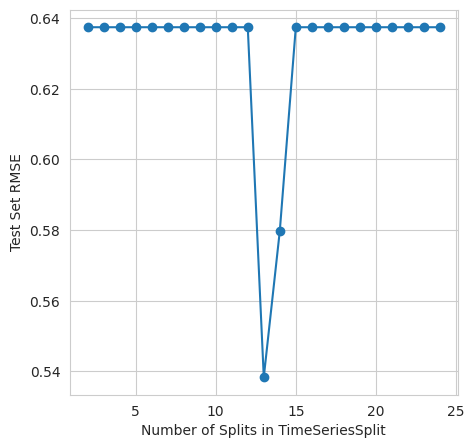

In [66]:
# Feature set for 'DC_POWER' and 'AMBIENT_TEMPERATURE'
feature_set = ['DC_POWER','AMBIENT_TEMPERATURE']

# Select relevant columns from the preprocessed 24-hour data
X = df_hrs_imputed_f[
    [col for col in df_hrs_imputed_f.columns if any(feat in col for feat in feature_set)]
]
y = df_m1['DC_POWER']  # Target variable is always 'DC_POWER'

# Split the data into training and testing sets
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# List to store RMSE values
rmse_values = []

# Iterate over different values for the number of splits in TimeSeriesSplit
split_values = range(2, 25)  # Our train set has 26 samples
for n_splits in split_values:
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Find best alpha using LassoCV with TimeSeriesSplit
    lasso_cv = LassoCV(alphas=np.linspace(0.001, 1, 1000), cv=tscv)
    lasso_cv.fit(X_train, y_train)
    
    # Extract the best alpha
    best_alpha = lasso_cv.alpha_
    
    # Fit Lasso model with best alpha
    model = Lasso(alpha=best_alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = mse(y_test, y_pred, squared=False)
    rmse_values.append(test_rmse)
    print(f"Number of splits: {n_splits}, RMSE: {test_rmse}")

# Plot RMSE vs. Number of Splits
plt.figure(figsize=(5, 5))
plt.plot(split_values, rmse_values, marker='o', linestyle='-')
plt.xlabel('Number of Splits in TimeSeriesSplit')
plt.ylabel('Test Set RMSE')
plt.grid(True)
plt.show()